In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.

['corpus_txt\\Doyle_AScandalinBohemia.txt',
 'corpus_txt\\Doyle_AStudyinScarlet.txt',
 'corpus_txt\\Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt\\Doyle_TheSignoftheFour.txt',
 'corpus_txt\\Howard_GodsoftheNorth.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [3]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

['Doyle_AScandalinBohemia.txt',
 'Doyle_AStudyinScarlet.txt',
 'Doyle_TheHoundoftheBaskervilles.txt',
 'Doyle_TheSignoftheFour.txt',
 'Howard_GodsoftheNorth.txt']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

#### Create Dictionaries

In [6]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id   
1      8194      1
       16387     1
       16389     4
       20489     1
       10        2

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [11]:
mm = MmCorpus("gensim_txt.mm")

In [12]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [13]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [14]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

In [15]:
len(features_to_be_removed)

75

In [16]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [17]:
mm = MmCorpus("gensim_txt.mm")

#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [18]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [19]:
len(doc2bow_list)

17

In [20]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

In [21]:
model.get_document_topics(doc2bow_list[1])

[(0, 0.04878821807076901),
 (6, 0.15392527596662184),
 (7, 0.049871377505205775),
 (10, 0.18388715691286564),
 (12, 0.10714738993984448),
 (13, 0.038963104862722364),
 (14, 0.029562505451684446),
 (15, 0.087012235715850969),
 (17, 0.17950665747388053),
 (18, 0.11878139246471454)]

In [22]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['worked-up',
 'vertebrates',
 'earthward',
 'ocular',
 'doin',
 'surgeons',
 'parts',
 'clambering',
 'stair',
 'gate']

In [23]:
#Topic probabilities
topics = model.show_topics(num_topics = 40)
topics

[(0,
  '0.006*"borders" + 0.005*"labrador" + 0.005*"cattle-herding" + 0.005*"domestic" + 0.004*"foggy" + 0.004*"africa" + 0.003*"handled" + 0.003*"educational" + 0.003*"running" + 0.003*"contracted"'),
 (1,
  '0.001*"worked-up" + 0.001*"vertebrates" + 0.001*"earthward" + 0.001*"ocular" + 0.001*"doin" + 0.001*"surgeons" + 0.001*"parts" + 0.001*"clambering" + 0.001*"stair" + 0.001*"gate"'),
 (2,
  '0.000*"rikk-tck" + 0.000*"foggy" + 0.000*"mean" + 0.000*"entangle" + 0.000*"thinnish" + 0.000*"witchlike" + 0.000*"loathsome" + 0.000*"asperity" + 0.000*"nine" + 0.000*"overly"'),
 (3,
  '0.000*"thinnish" + 0.000*"rikk-tck" + 0.000*"holes" + 0.000*"nine" + 0.000*"contracted" + 0.000*"carted" + 0.000*"tries" + 0.000*"exerting" + 0.000*"entangle" + 0.000*"mean"'),
 (4,
  '0.000*"witchlike" + 0.000*"skins" + 0.000*"nine" + 0.000*"contracted" + 0.000*"overly" + 0.000*"mean" + 0.000*"cattle-herding" + 0.000*"foggy" + 0.000*"incommodes" + 0.000*"steaming"'),
 (5,
  '0.000*"carted" + 0.000*"loathsome

In [24]:
import pandas as pd
import regex as re
def gensim2dataframe(model):
    num_topics = model.num_topics
    topics_df = pd.DataFrame(index = range(num_topics), columns= range(10))

    topics = model.show_topics(num_topics)
    
    for topic_dist in topics:    
        idx = topic_dist[0]
        temp = re.findall(r'\"(.+?)\"', topics[idx][1])
        topics_df.loc[idx] = temp
    
    return topics_df

In [25]:
topics_df = gensim2dataframe(model)

In [32]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,borders,worked-up,rikk-tck,thinnish,witchlike,carted,carted,flecked,overly,absorb,canal,foggy,singing,strips,nebular,carted,parvo,flecked,worked-up,carted
1,labrador,vertebrates,foggy,rikk-tck,skins,loathsome,cynicism,mean,cattle-herding,faded,nine,flecked,boiler-clean,railings,interview,entangle,recruit-mule,tries,flecked,nine
2,cattle-herding,earthward,mean,holes,nine,rikk-tck,rikk-tck,named,carted,pools,meditation,thinnish,witchlike,majestic,bearlings,rikk-tck,scuffle,thinnish,start,thinnish
3,domestic,ocular,entangle,nine,contracted,sapping,fixing,shin,steaming,high-swinging,overly,witchlike,labrador,carted,nags,exerting,sake,skins,lanterns,witchlike
4,foggy,doin,thinnish,contracted,overly,slued,slued,steed,witchlike,canal,daren't,mean,eloquently,bullock-driver,mailed,train,rarest,rikk-tck,mitral,asperity
5,africa,surgeons,witchlike,carted,mean,overly,parent,foggy,skins,twice,parry,loathsome,baker,badly-trimmed,thinnish,well-dressed,murcher's,contracted,screaming,overly
6,handled,parts,loathsome,tries,cattle-herding,fixing,running,bullock-driver,nine,yelps,witchlike,nine,earthly,earth,craving,swindling-stable,lanky,oasis,cattle-herding,incommodes
7,educational,clambering,asperity,exerting,foggy,asperity,thinnish,rikk-tck,ridicule,chamois-leather,contracted,oasis,contracted,entangle,smacked,foreseeing,patent-leathers,disappointment,asperity,perspectively
8,running,stair,nine,entangle,incommodes,witchlike,entangle,eloquent,continuous,e's,perspectively,holes,ridicule,cannot,overly,establishment,weight,nine,overly,ductile
9,contracted,gate,overly,mean,steaming,skins,asperity,disconsolate,mean,discovering,unaccustomed,asperity,mcgregor,inseparable,tries,spent,clanking,bearlings,ransacking,tries


## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-package

<module 'matplotlib.pyplot' from 'c:\\users\\philip\\appdata\\local\\programs\\python\\python35-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

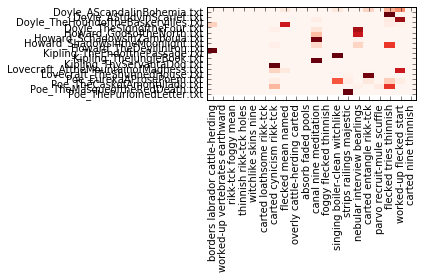

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

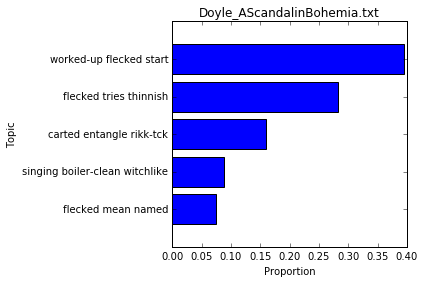

In [30]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)